In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy
import anndata
import torch
from torch import tensor as tt
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

from utils import *

# **Spatial fit**

In this notebook we try to fit some functions that describe the change  
in space of gene expression in the mice brain. Since it is bulk sequencing  
there are several cell typer which add variarion and might pollute our data

In [2]:
# immport the anndata file
adata = sc.read_h5ad("data/adata_hexagon.h5ad")
adata


AnnData object with n_obs × n_vars = 82 × 27462
    obs: 'x', 'y', 'z', 'counts'
    layers: 'log', 'norm'

In [3]:
zonated_genes = np.array(
    ["Vip", "Avp", "Prok2", "Penk", "Vipr2", "Avpr1a", "Cck", "Grp", "Syt1"]
)

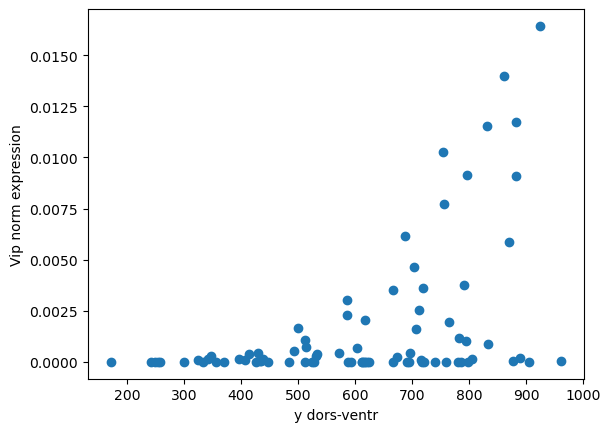

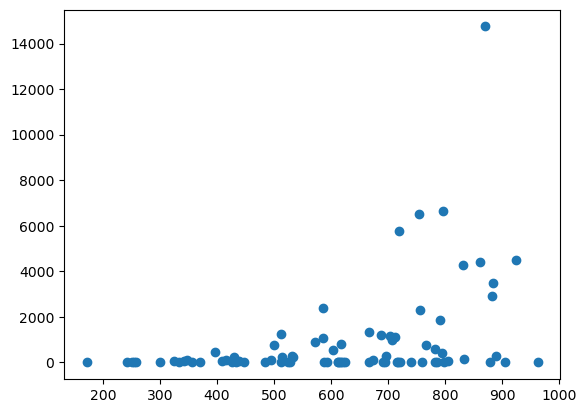

In [4]:
# plot Vip agaonst y coord
plt.scatter(adata.obs["y"], adata[:, "Vip"].layers["norm"])
plt.xlabel("y dors-ventr")
plt.ylabel("Vip norm expression")
# plt.yscale('log')
plt.show()
# now non noralied data
plt.scatter(adata.obs["y"], adata[:, "Vip"].X)


In [5]:
# create a matrix with x , y and z obs from adata, joining the 3 vectors as three columns
# and then convert it to a tensor

coord = np.stack((adata.obs["x"], adata.obs["y"], adata.obs["z"]), axis=-1)
# normalize the data
coord = (coord - coord.mean(axis=0)) / coord.std(axis=0)

xx = np.linspace(coord[:, 0].min(), coord[:, 0].max(), 1000)
yy = np.linspace(coord[:, 1].min(), coord[:, 1].max(), 1000)
zz = np.linspace(coord[:, 2].min(), coord[:, 2].max(), 1000)

# vector of variables used to plot
space = np.stack((xx, yy, zz), -1)
space


array([[-1.52578004, -2.30725508, -1.97932127],
       [-1.52205828, -2.30308561, -1.97523406],
       [-1.51833653, -2.29891614, -1.97114684],
       ...,
       [ 2.18480687,  1.84971023,  2.09563245],
       [ 2.18852862,  1.8538797 ,  2.09971967],
       [ 2.19225037,  1.85804918,  2.10380688]])

# scipy model

Model 1: BIC = 6728.41
Model 2: BIC = 4924.53
Model 3: BIC = 4716.22


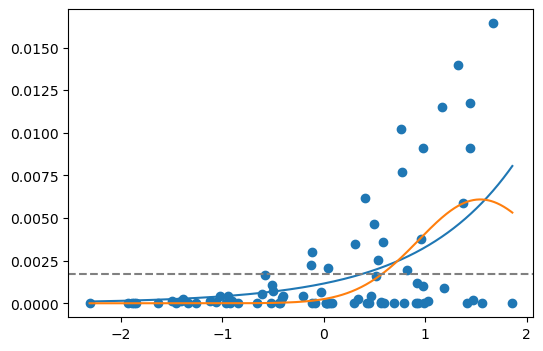

In [8]:
x = coord[:, 1]  # y
y = adata[:, "Vip"].layers["norm"].squeeze()  # expression
n = NC  # number of samples
# model 1
mean_y = np.mean(y)
mse1 = LL(y, np.full_like(y, mean_y))
bic1 = calculate_bic(n, mse1, 1)

# Model 2: Exponential Line
params2, _ = curve_fit(exp_line, x, y)
y_pred2 = exp_line(x, *params2)
mse2 = LL(y, y_pred2)
bic2 = calculate_bic(n, mse2, 2)

# Model 3: Exponential Parabola
params3, _ = curve_fit(exp_parabola, x, y)
y_pred3 = exp_parabola(x, *params3)
mse3 = LL(y, y_pred3)
bic3 = calculate_bic(n, mse3, 3)

print("Model 1: BIC = {:.2f}".format(bic1))
print("Model 2: BIC = {:.2f}".format(bic2))
print("Model 3: BIC = {:.2f}".format(bic3))

# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="data")
plt.plot(yy, exp_line(yy, *params2), label="exponential line")
plt.plot(yy, exp_parabola(yy, *params3), label="exponential parab")

# plot horizontal line
plt.axhline(mean_y, color="grey", ls="--", label="mean")

## parabola fits

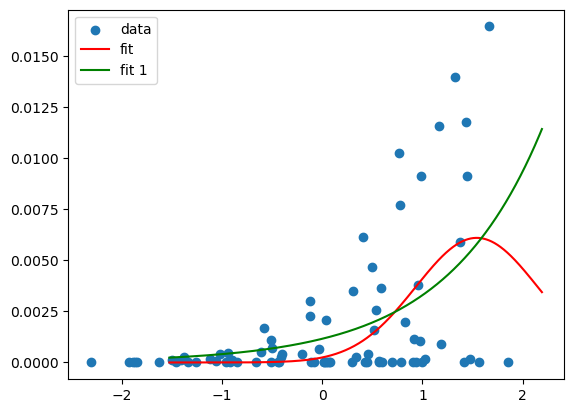

In [10]:
# same fit and plot but fitting vip

coef, _ = curve_fit(
    func_2, coord[:, 1], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0, 0)
)

plt.scatter(coord[:, 1], adata[:, "Vip"].layers["norm"], label="data")
plt.plot(xx, func_2(xx, *coef), c="r", label="fit")

# loss
loss_vip_y = np.sum(
    (adata[:, "Vip"].layers["norm"].squeeze() - func_2(coord[:, 1], *coef)) ** 2
)

# fit with vip but with func
coef1, _ = curve_fit(
    func, coord[:, 1], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0)
)
plt.plot(xx, func(xx, *coef1), c="g", label="fit 1")
plt.legend()

In [11]:
space_labels = np.array(["med-lat", "dors-vent", "ant-post"])

# create a vector to store the fitted parameters
# N_genes x N_space_labels x N_parameters
theta = np.zeros((len(zonated_genes), 3, 3))
theta[0, 0, :]


array([0., 0., 0.])

In [22]:
# now fit all the zonated genes, and plot the output of the fit
# for every gene plot the 3 dimensions side by side

# for i, g in enumerate(zonated_genes):
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(g)
#     for d in range(3):
#         theta[i, d, :], _ = curve_fit(
#             func_2, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0)
#         )
#         plt.subplot(1, 3, d + 1)
#         plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
#         plt.plot(space[:, d], func_2(space[:, d], *theta[i, d, :]), c="r", label="fit")
#         plt.xlabel(space_labels[d])
#         plt.title(theta[i, d, :][0] / _.diagonal()[0])
#         # plt.yscale('log')

#     plt.show()


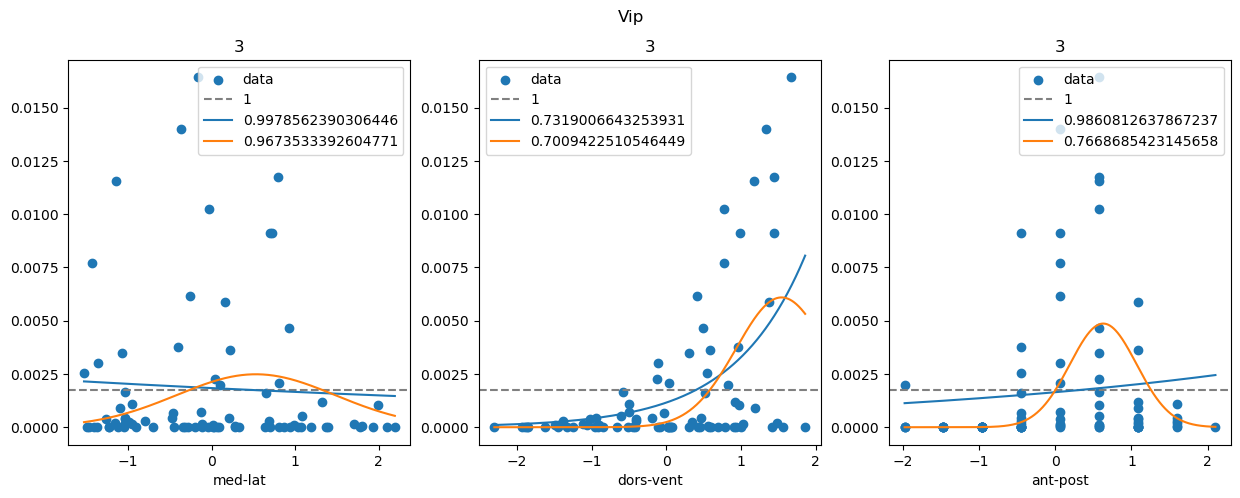

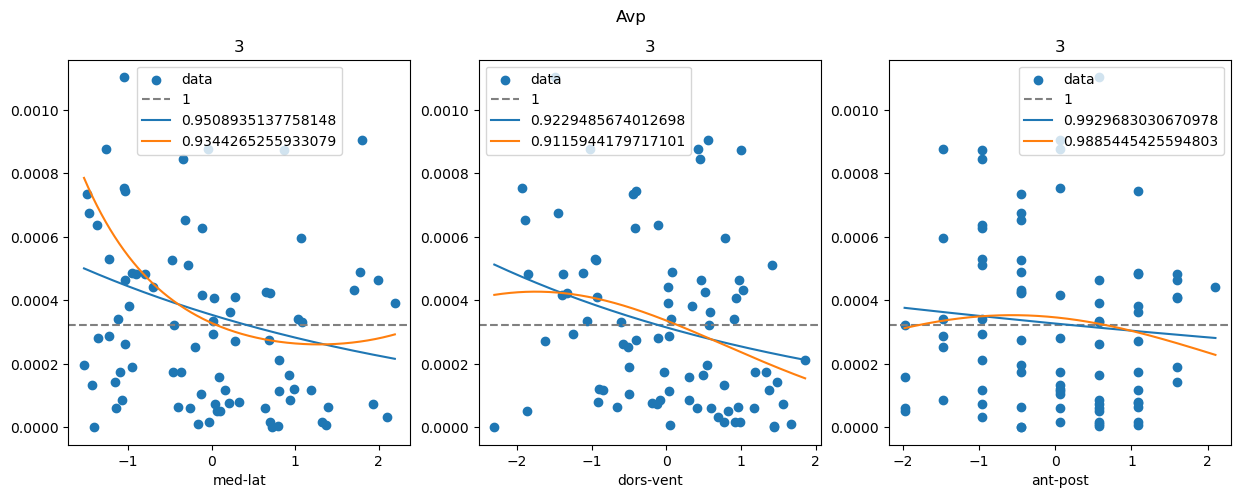

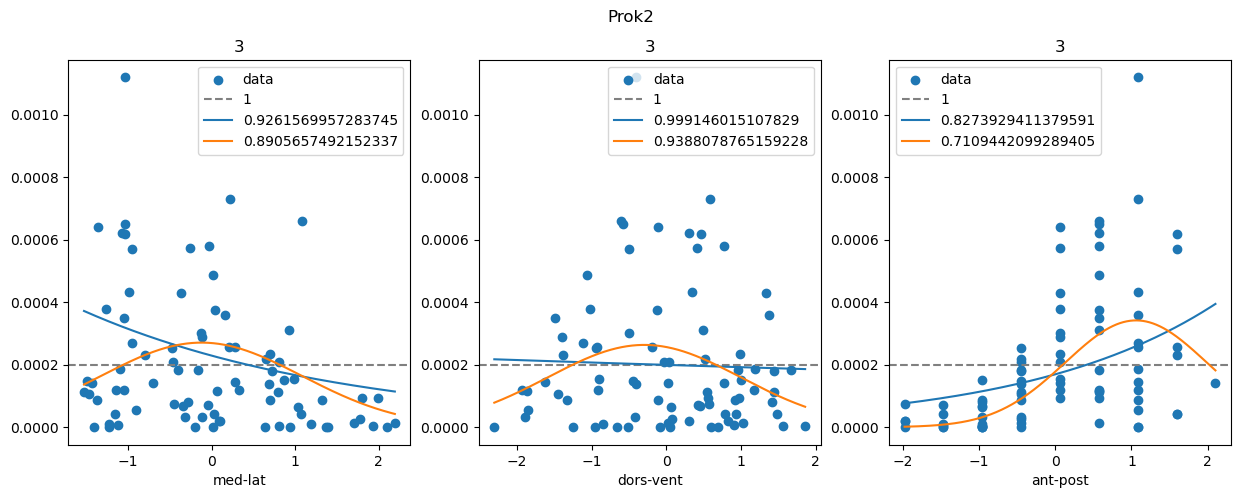

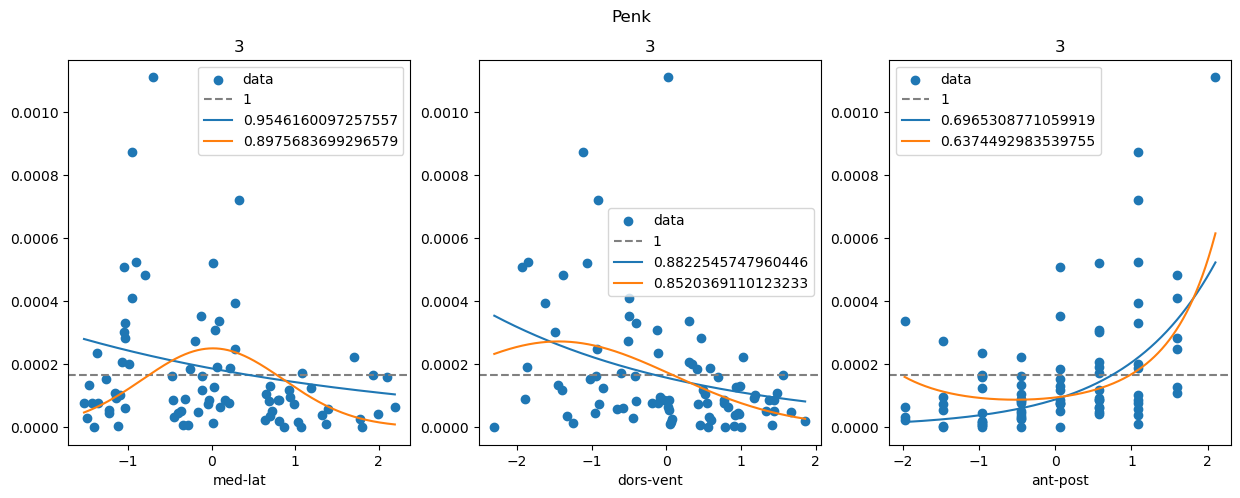

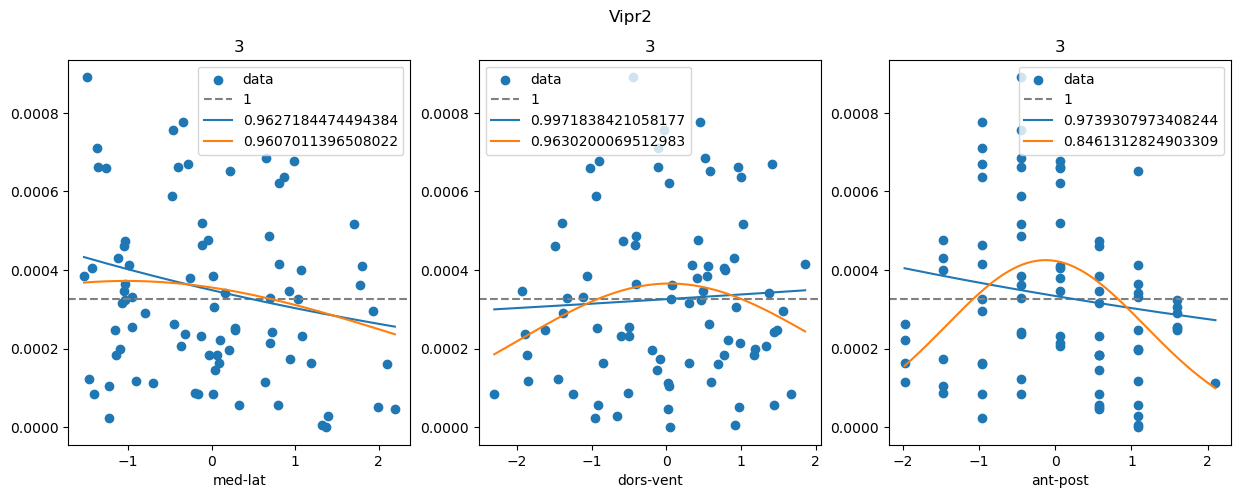

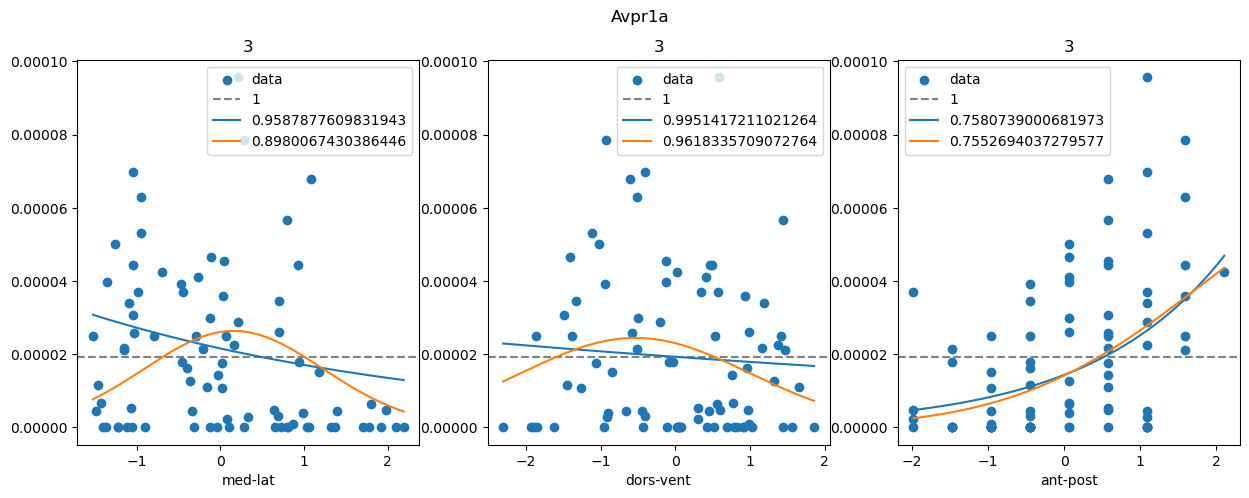

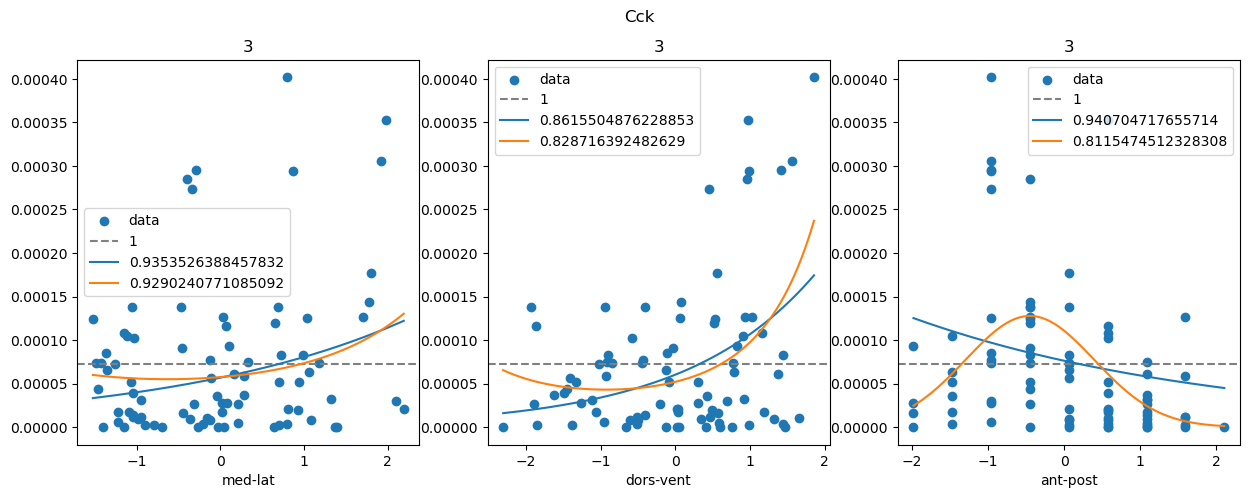

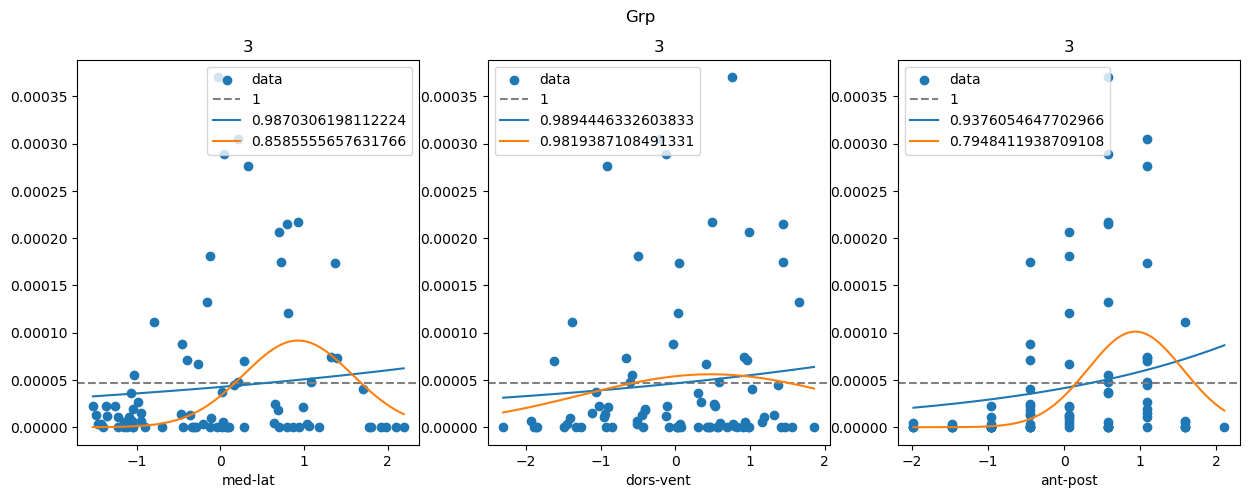

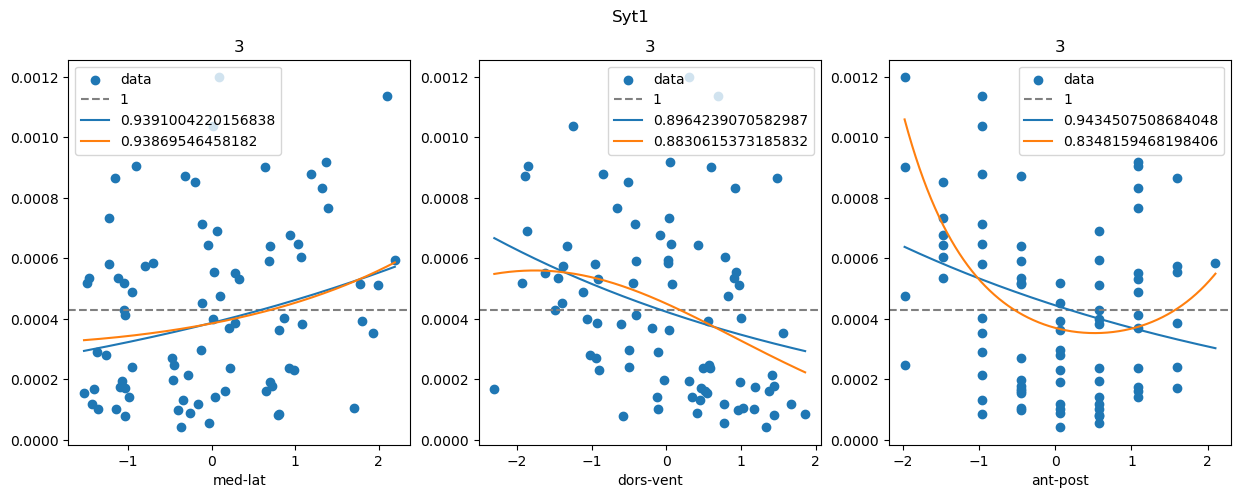

In [32]:
# now I want to do the same but for every gene, and for every dimension
# I want to fit the data with the 3 models seprately and then compare the BIC
# plots are just like before but we plot all 3 the fits, and as a legend we put the BIC

for i, g in enumerate(zonated_genes):
    plt.figure(figsize=(15, 5))
    plt.suptitle(g)
    for d in range(3):
        # fit the data with the 3 models
        # model 1
        mean_y = np.mean(adata[:, g].layers["norm"].squeeze())
        mse1 = LL(
            adata[:, g].layers["norm"].squeeze(),
            np.full_like(adata[:, g].layers["norm"].squeeze(), mean_y),
        )
        bic1 = calculate_bic(n, mse1, 1)

        # model 2
        params2, _ = curve_fit(
            exp_line, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0)
        )
        y_pred2 = exp_line( coord[:, d], *params2)
        mse2 = LL(adata[:, g].layers["norm"].squeeze(), y_pred2)
        bic2 = calculate_bic(n, mse2, 2)

        # model 3
        params3, _ = curve_fit(
            exp_parabola, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0)
        )
        y_pred3 = exp_parabola( coord[:, d], *params3)
        mse3 = LL(adata[:, g].layers["norm"].squeeze(), y_pred3)
        bic3 = calculate_bic(n, mse3, 3)

        # nor with sme if statement check which is the best model

        # plot the data
        plt.subplot(1, 3, d + 1)
        plt.title(np.argmin([bic1, bic2, bic3]) + 1)
        plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
        # plot horizontal line
        plt.axhline(mean_y, color="grey", ls="--", label=1)
        plt.plot(space[:, d], exp_line(yy, *params2), label=bic2/bic1)
        plt.plot(space[:, d], exp_parabola(yy, *params3), label=bic3/bic1)
        # plot horizontal line
        plt.xlabel(space_labels[d])
        plt.legend()


    # plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

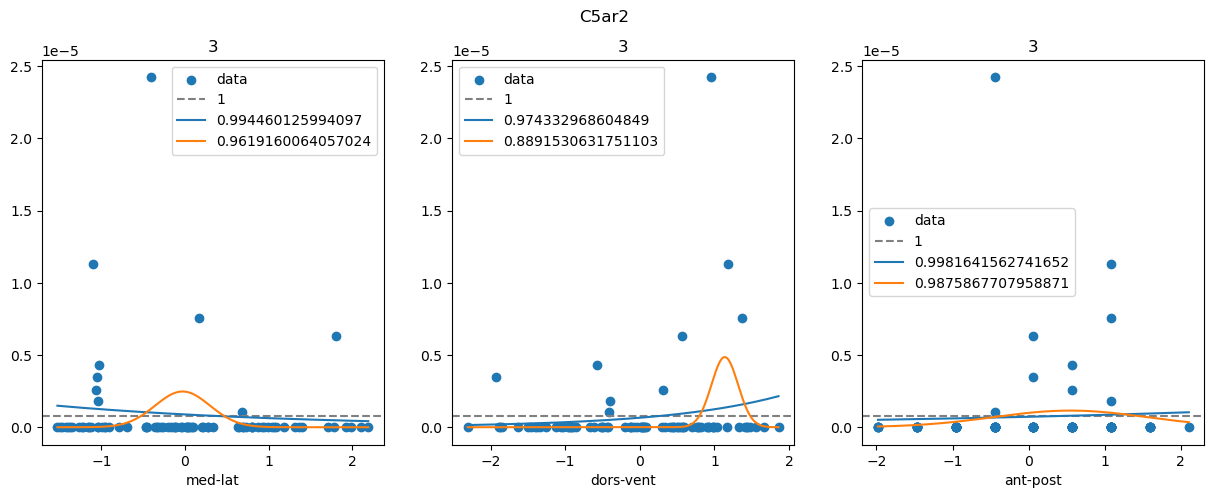

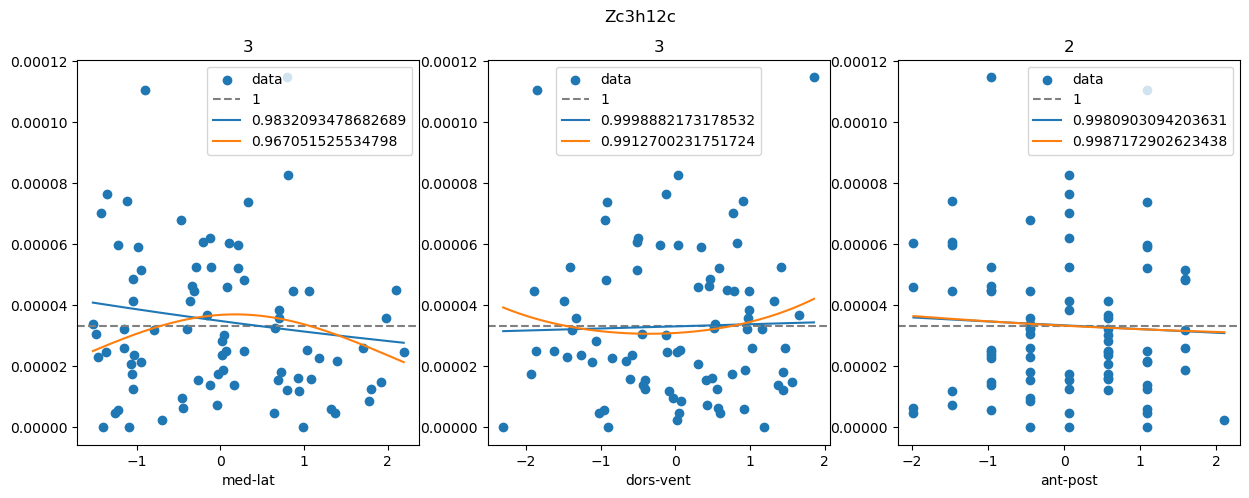

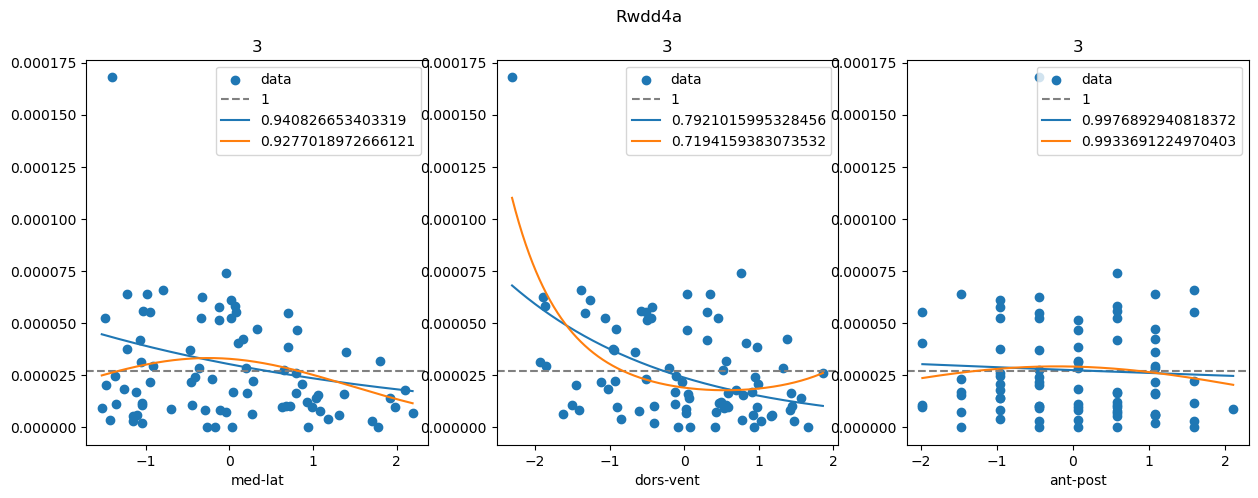

<Figure size 1500x500 with 0 Axes>

In [38]:
genes = adata.var_names
#take random 10 genes
genes_random = np.random.choice(genes, 10)

for i, g in enumerate(genes_random):
    plt.figure(figsize=(15, 5))
    plt.suptitle(g)
    for d in range(3):
        # fit the data with the 3 models
        # model 1
        mean_y = np.mean(adata[:, g].layers["norm"].squeeze())
        mse1 = LL(
            adata[:, g].layers["norm"].squeeze(),
            np.full_like(adata[:, g].layers["norm"].squeeze(), mean_y),
        )
        bic1 = calculate_bic(n, mse1, 1)

        # model 2
        params2, _ = curve_fit(
            exp_line, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0)
        )
        y_pred2 = exp_line( coord[:, d], *params2)
        mse2 = LL(adata[:, g].layers["norm"].squeeze(), y_pred2)
        bic2 = calculate_bic(n, mse2, 2)

        # model 3
        params3, _ = curve_fit(
            exp_parabola, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0)
        )
        y_pred3 = exp_parabola( coord[:, d], *params3)
        mse3 = LL(adata[:, g].layers["norm"].squeeze(), y_pred3)
        bic3 = calculate_bic(n, mse3, 3)

        # nor with sme if statement check which is the best model

        # plot the data
        plt.subplot(1, 3, d + 1)
        plt.title(np.argmin([bic1, bic2, bic3]) + 1)
        plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
        # plot horizontal line
        plt.axhline(mean_y, color="grey", ls="--", label=1)
        plt.plot(space[:, d], exp_line(yy, *params2), label=bic2/bic1)
        plt.plot(space[:, d], exp_parabola(yy, *params3), label=bic3/bic1)
        # plot horizontal line
        plt.xlabel(space_labels[d])
        plt.legend()


In [14]:
#     theta[i, d, :], _ = curve_fit(
#         func_2, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0)
#     )
#     plt.subplot(1, 3, d + 1)
#     plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
#     plt.plot(space[:, d], func_2(space[:, d], *theta[i, d, :]), c="r", label="fit")
#     plt.xlabel(space_labels[d])
#     plt.title(theta[i, d, :][0] / _.diagonal()[0])
#     # plt.yscale('log')

now in the next phase I want to find new genes that are zonated in the same way as the known ones //
therefore I have two possibilities:
-  fit new genes in the same way and sort of capture the ones with the small zonated profiles based on the fitted parameters
-  correlation analysis: it's important to devide monotone genes from the ones with a peak. than look at monotone genes and peake one separately

In [44]:
print("       a                   b                  c")
theta[0, :, :]

# fixed theg ene and the dimension, caluclae x= -b / 2a , the position of the maximum/minimum
# if the position is outside the range of the data, then the probably a linear fit is better
# than print these values

for i, g in enumerate(zonated_genes):
    for d in range(3):
        print(g, space_labels[d], -theta[i, d, 1] / (2 * theta[i, d, 0]))


       a                   b                  c
Vip med-lat -0.004599094311432241
Vip dors-vent 1.541660533295475
Vip ant-post 0.3544080587539856
Avp med-lat 0.8434700444333686
Avp dors-vent -1.7534211445919574
Avp ant-post -0.8659560814147206
Prok2 med-lat -0.7326844146732343
Prok2 dors-vent -0.2972730408935418
Prok2 ant-post 0.7942089111572064
Penk med-lat -0.58028706978214
Penk dors-vent -1.4466178152943021
Penk ant-post -0.8186791140615262
Vipr2 med-lat -1.7432378064220535
Vipr2 dors-vent 0.04086518621942872
Vipr2 ant-post -0.4184017524458168
Avpr1a med-lat -0.4213344851870929
Avpr1a dors-vent -0.5353413004290005
Avpr1a ant-post 4.017005422857526
Cck med-lat -1.3118092132765924
Cck dors-vent -0.9281660264691628
Cck ant-post -0.74743443608552
Grp med-lat 0.44126595018690845
Grp dors-vent 0.4767255360476616
Grp ant-post 0.6658935680879375
Syt1 med-lat -3.788652638164564
Syt1 dors-vent -1.7657825099355433
Syt1 ant-post 0.24113779597976698


# 3D spatial fit

Now we will use the following model:  

**2D**  
we start from Vip which is mainly zonated in directions only. acutally for vip the dims are y and z.  
in the end we want somethig: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + c )  
\end{equation}

**3D**  
in the end we want: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + b_z z_i^2  +b_z z_i + c )  
\end{equation}

## experimenting with Vip

In [45]:
# fit all the genes
yz = coord[:, [1, 2]]
theta_2D = np.zeros((len(zonated_genes), 5))
losses_2D = np.zeros(len(zonated_genes))
for i, g in enumerate(zonated_genes):
    theta_2D[i, :], _ = curve_fit(
        func_2D, yz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0)
    )
    # loss
    losses_2D[i] = loss_2D(
        coord[:, [1, 2]], adata[:, g].layers["norm"], *theta_2D[i, :]
    )

In [46]:
print(theta_2D.shape)
zonated_genes


(9, 5)


array(['Vip', 'Avp', 'Prok2', 'Penk', 'Vipr2', 'Avpr1a', 'Cck', 'Grp',
       'Syt1'], dtype='<U6')

In [47]:
#  create a df with the fitted parameters
df = pd.DataFrame(
    theta_2D,
    index=zonated_genes,
    columns=["ay", "by", "az", "bz", "c"],
)
# save df to csv
df.to_csv("fit/theta_2D.csv")

In [48]:
# np.where(adata.var == 'Vip')
adata.var.index.get_loc("Vip")

14804

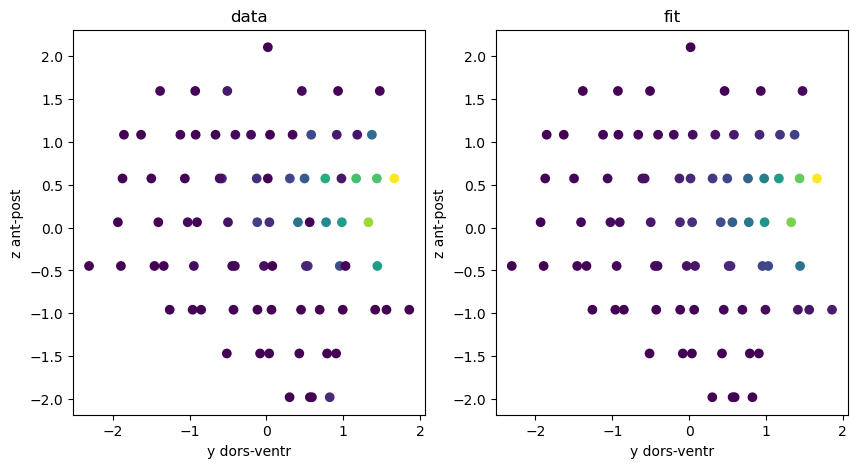

In [49]:
# fit the 2D function to the data
gene = "Vip"

# plot the fit SIDE BY SIDE with the data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(yz[:, 0], yz[:, 1], c=adata[:, gene].layers["norm"].squeeze())
plt.title("data")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")

plt.subplot(1, 2, 2)
plt.scatter(
    yz[:, 0], yz[:, 1], c=func_2D(yz.T, *theta_2D[ind_z(zonated_genes, gene), :])
)
plt.title("fit")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()


In [50]:
# fit 3D model to vip counts
xyz = coord[:, [0, 1, 2]]

# fit
coef, _ = curve_fit(
    func_3D, xyz.T, adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0, 0, 0)
)

# loss
Y_hat = func_3D(xyz.T, *coef)
loss_vip_3D = np.sum((adata[:, "Vip"].layers["norm"].squeeze() - Y_hat) ** 2)
coef

array([-0.32194743, -0.15893787, -0.49823985,  1.86412033, -1.90738963,
        1.07369843, -5.81855123])

Loss functions get definetly smaller

In [51]:
print(
    "loss 3D ",
    loss_vip_3D,
    "loss only y ",
    loss_vip_y,
    "loss only z ",
    loss_vip_z,
)

loss 3D  5.9022474146021875e-05 loss only y  0.0006947759689121867 loss only z  0.000760305986528579


In [52]:
# fitting all zonated genes in 3D
# create a vector to store the fitted parameters
# N_genes x  N_parameters
theta = np.zeros((len(zonated_genes), 7))
# save losses
losses = np.zeros(len(zonated_genes))
print(theta.shape)
# now fit all the zonated genes
for i, g in enumerate(zonated_genes):
    theta[i, :], _ = curve_fit(
        func_3D, xyz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0, 0, 0)
    )
    losses[i] = loss_3D(xyz, adata[:, g].layers["norm"].squeeze(), *theta[i, :])

(9, 7)


In [53]:
# create a df with the fitted parameters
df = pd.DataFrame(
    theta,
    index=zonated_genes,
    columns=["ax", "bx", "ay", "by", "az", "bz", "c"],
)
# save df to csv
# df.to_csv("fit/theta_3D.csv")

In [115]:
# print side by side the losses andthe gene name
for i, g in enumerate(zonated_genes):
    print(g, losses[i])


Vip tensor(65401.8293, dtype=torch.float64)
Avp tensor(80480.4421, dtype=torch.float64)
Prok2 tensor(53882.5514, dtype=torch.float64)
Penk tensor(44682.1041, dtype=torch.float64)
Vipr2 tensor(68481.6777, dtype=torch.float64)
Avpr1a tensor(57821.2977, dtype=torch.float64)
Cck tensor(51525.0247, dtype=torch.float64)
Grp tensor(72378.8330, dtype=torch.float64)
Syt1 tensor(65502.8505, dtype=torch.float64)


Text(0, 0.5, 'Vip norm expression')

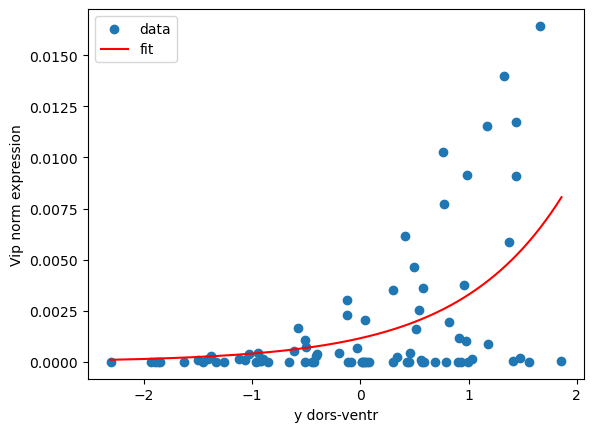

In [134]:
coef, _ = curve_fit(
    func, coord[:, 1], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0)
)

plt.scatter(coord[:, 1], adata[:, "Vip"].layers["norm"], label="data")
plt.plot(yy, func(yy, *coef), c="r", label="fit")
plt.legend()
plt.xlabel("y dors-ventr")
plt.ylabel("Vip norm expression")
